# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [2]:
xr.set_options(display_style='text')

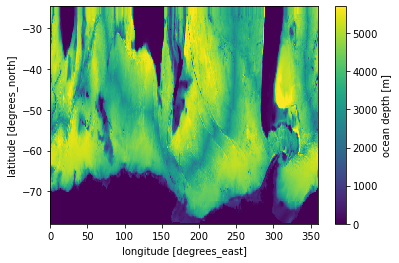

In [8]:
coords.Depth.plot()

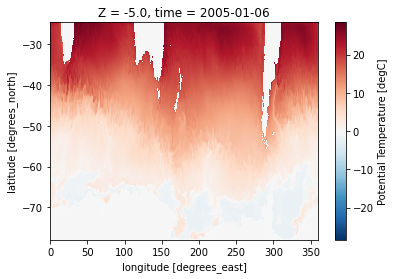

In [13]:
ds_tns.THETA[0,0].plot()

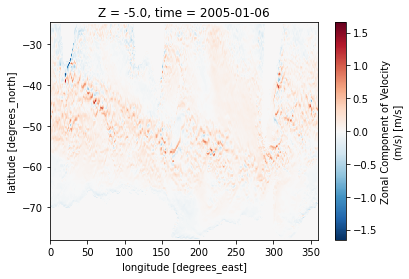

In [12]:
ds_vel.UVEL[0,0].plot()

## **Need to roll the ds plotted above**

In [19]:
#coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) #didn't upload wg region
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/coords.zarr'))
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta_wg.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_wg.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/drhodts_wg.zarr'))
ds_tmp_slt_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_slt_wg.zarr')) #from sigma-budget-zspace-sose.ipynb
ds = xr.merge([ds_tns, ds_tmp_slt_wg, ds_vel])
ds

GroupNotFoundError: group not found at path ''

In [6]:
coords = coords.roll(XC=700, XG=700)
ds = ds.roll(XC=700, XG=700)

<ipython-input-6-cc4a553a0312>:1: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  coords = coords.roll(XC=700, XG=700)
<ipython-input-6-cc4a553a0312>:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds = ds.roll(XC=700, XG=700)


## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial t} \end{equation*} </font>

In [7]:
#change levels to pressure
pressure = xr.apply_ufunc(gsw.p_from_z, ds.Z, ds.YC, 
                          output_dtypes=[ds.Z],
                          dask='parallelized').reset_coords(drop=True).load()

In [25]:
drhodt = jmd95numba.drhodt(ds.SALT, ds.THETA, pressure)
drhodt

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<drhodt, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [26]:
mean = drhodt.mean(dim=['time', 'Z'])

In [27]:
mean

<xarray.DataArray (YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(95, 570), dtype=float64, chunksize=(95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083

In [18]:
mean.plot()

AttributeError: module '__mp_main__' has no attribute 'drhodt'

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \end{equation*} </font>

In [9]:
drhods = jmd95numba.drhods(ds.SALT, ds.THETA, pressure)
drhods

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<drhods, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31